In [1]:
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split
import lightgbm
import xgboost
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 1. READ data
order = pd.read_csv('./orders.csv')
prod = pd.read_csv('./products.csv')

order.head(3)
prod.head(3)

,website_name,product_id,product_name,category_name,description,manufacturer_name,weight,dimension_1,dimension_2,dimension_3,num_reviews,onsite_price,on_promotion
0,Joss US,2794209975853350000,Westgate Upholstered Panel Bed,Beds,The 1882 upholstered bed is sure to appeal to ...,Pulaski Furniture,116.0,59.25,87.50,68.75,7.0,409.99,0.0
1,Joss US,8187816211386240000,3 Piece Leah Bowl Set,"Boxes, Bins, Baskets, & Buckets",Stack green apples on the breakfast bar or dis...,Three Hands Co.,30.8,23.00,28.35,14.17,0.0,89.99,1.0
2,Joss US,7241740433485130000,Butter Cups/Ranunculus Sunshine Bulb,Planting & Seeding,Start your own backyard garden or add spring s...,Van Zyverden Inc,1.0,16.00,3.00,4.00,0.0,16.99,0.0


In [3]:
# 2. Data Precessing, cleaning

#2.1
join_product = set(order['wayfair_product_id'].unique())&set(prod['product_id'].unique())
print('len of commen product:', len(join_product))

#27163 unique product is enough for model training

len of commen product: 27163


In [4]:
#2.2 join data of table : products and orders

new = order.merge(prod, how='inner', left_on='wayfair_product_id', 
            right_on='product_id', left_index=False)

# Value: this is the Y(result) in this poredictive model
new['value'] = new['onsite_price'] * new['quantity_ordered'] 

In [5]:
new.columns

Index(['order_product_id', 'order_id', 'wayfair_product_id',
       'wayfair_website_id', 'order_date', 'order_time', 'customer_id',
       'customer_zip', 'quantity_ordered', 'website_name', 'product_id',
       'product_name', 'category_name', 'description', 'manufacturer_name',
       'weight', 'dimension_1', 'dimension_2', 'dimension_3', 'num_reviews',
       'onsite_price', 'on_promotion', 'value'],
      dtype='object')

In [6]:
#2.3 data clean

#drop null zip, 36 rows is fine, 
sum(new['customer_zip'].isnull())  
new = new[pd.notnull(new['customer_zip'])]

#we delete the bad records, e.g., zipcode lenth is 1, 2, 11, etc.
new = new[new['customer_zip'].apply(lambda x: len(str(x)) in [4, 5])]

print('Number of data will be using:', new.shape[0])

Number of data will be using: 67300


In [7]:
# 2.4 feature engineering: and eda

# date->day of week,
new['order_date'] =  new['order_date'].apply(
    lambda x: datetime.datetime.strptime(x, '%m/%d/%y').weekday())

#time->categorical,
new['order_time'] = new['order_time'].apply(
    lambda x: int(x.split(':')[0]))

# len(description)
new['description'] = new['description'].apply(lambda x: len(x))

<function matplotlib.pyplot.show(*args, **kw)>

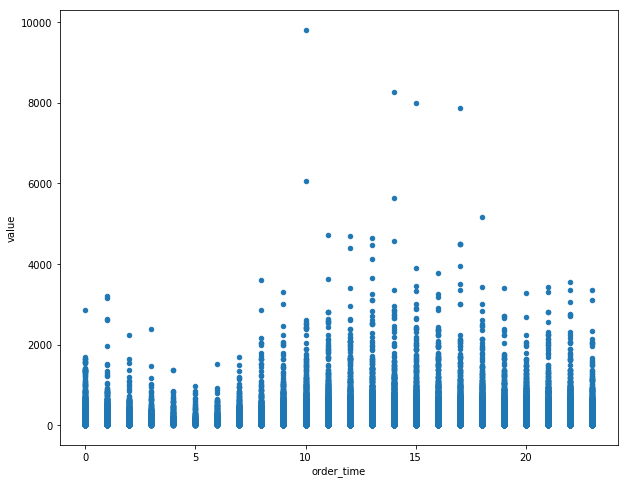

In [54]:
new.plot(x='order_time', y='value', kind='scatter', figsize=(10, 8))
plt.savefig("3.png", dpi = 600)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

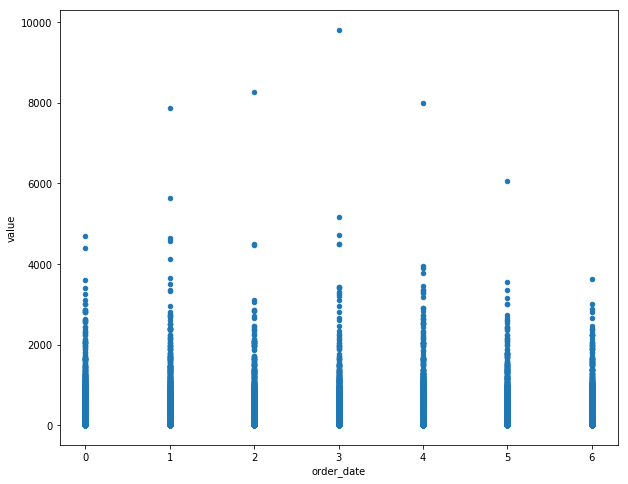

In [52]:
new.plot(x='order_date', y='value', kind='scatter', figsize=(10, 8))
plt.savefig("1.png", dpi = 600)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

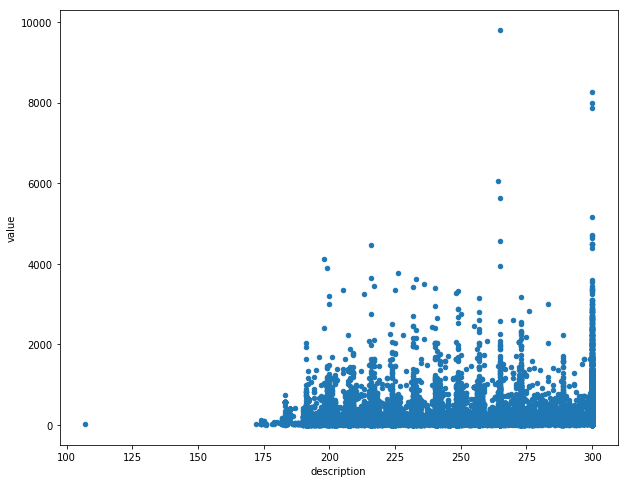

In [53]:
new.plot(x='description', y='value', kind='scatter', figsize=(10, 8))
plt.savefig("2.png", dpi = 600)
plt.show

In [9]:
# Categorize data

new["product_name"].astype('category')
new["category_name"].astype('category')
new["manufacturer_name"].astype('category')
print('Categorize data, done')

Categorize data, done


In [10]:
#use weight ranking within item categoricay as feature

weight_cat = new.groupby(by = 'category_name').mean()['weight']
new['cat_weight'] = new['category_name'].apply(lambda x: weight_cat[x])
new['weight'] = new['weight'] / new['cat_weight']  

In [11]:
# introduce house price as customers' buying power

#imprort data
tax = pd.read_csv('./taxes.csv')

#use 'income' to describe income
tax['income'] = tax['agi_stub'] * tax['num_returns']
tax_level = tax.groupby('zipcode').mean()['income']

In [46]:
# join table

def ts(x):
    try:
        if int(x) and int(x) in tax_level.index:
            return str(tax_level[int(x)])
    except:
        return None    

new['salary'] = new['customer_zip'].apply(ts)
new["salary"].astype('category')
print('done')


# clean data: use the sale price nearby to fill the nans
new.sort_values(by='customer_zip')
new['salary'] = new['salary'].fillna( method='backfill')
new['salary'] = new['salary'].apply(lambda x: int(float(x)))

done


In [ ]:
#use two digits of zipcode as geo info

def zipp(x):
    x = str(x)
    if len(x) == 4:
        x = '0' + str(x)
        return x[:2]
    return x[:2]

new['state'] = new['customer_zip'].apply(zipp)
print('done')

In [47]:
#regression model:

features = [ 'order_date', 'order_time', 'description', 'weight',  'onsite_price',# 'state'
             'num_reviews', 'on_promotion',  'salary']   #'salary'
target = ['value']
X = new[features]
y = new[target]
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [49]:
testScore=math.sqrt(mean_squared_error(y_test.values,y_pred))
print('Score:', testScore)
xgb.feature_importances_

Score: 145.62663060052705


array([0.07681142, 0.09531873, 0.06556188, 0.17213015, 0.28898028,
       0.1589452 , 0.00774162, 0.13451071], dtype=float32)